In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/survey.csv'
df = pd.read_csv(path, encoding='latin1')

df = df.drop(columns=['comments', 'Timestamp', 'state', 'no_employees', 'anonymity'])
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df['self_employed'] = df['self_employed'].fillna('No')
df.drop_duplicates()
df['work_interfere'] = df['work_interfere'].fillna('Not applicable')

#Function to clean the gender variable into 'female', 'male', and 'other'
def clean_gender(gender):
    gender = str(gender).strip().lower()
    if gender in ['male', 'm', 'cis male', 'male (cis)', 'man', 'mail', 'cis man', 'malr', 'make', 'maile']:
        return 'Male'
    elif gender in ['female', 'f', 'cis female', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'femail', 'female ', 'trans female']:
        return 'Female'
    else:
        return 'Other'

# Apply the cleaning function
df['Gender'] = df['Gender'].apply(clean_gender)

for col in ['Gender','Country','self_employed','family_history','work_interfere','remote_work','tech_company','benefits','care_options',
            'wellness_program','seek_help','leave','mental_health_consequence','phys_health_consequence','coworkers','supervisor',
            'mental_health_interview','phys_health_interview','mental_vs_physical','obs_consequence']:
            vc = df[col].value_counts(normalize=True)
            rare = vc[vc < 0.01]

vc = df['Country'].value_counts(normalize=True)
rare = vc[vc < 0.01]
rare_labels = rare.index.tolist()
df['Country_grouped'] = df['Country'].replace(rare_labels, 'Other')

!pip install matplotlib-venn

# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

!pip install cartopy
import cartopy

!apt-get update -qq
!apt-get install -y libarchive-dev

!pip install libarchive-c

# Test
import libarchive
print("Import succeeded:", libarchive)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score

# 1. Load and preprocess data
df['treatment'] = df['treatment'].map({'Yes': 1, 'No': 0})

# 2. Define features and target
cat_cols = [
    'Gender', 'Country_grouped', 'self_employed', 'family_history',
    'work_interfere', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'leave',
    'mental_health_consequence', 'phys_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview',
    'phys_health_interview', 'mental_vs_physical', 'obs_consequence'
]
num_cols = ['Age']
target = 'treatment'

X = df[cat_cols + num_cols]
y = df[target]

Mounted at /content/drive
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.4_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.4) ...
Processing triggers for man-db (2.10.2-1) ...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=3e97303d97d87a93f774417fae22f5f726faa6c49888e332ca9718cd5d2b8976
  Stored in directory: /root/.cache/pip/wheels/32/98/bd/4893d6923dd027f455b250367d402bfd69a6f4416581df46db
Successfully built libarchive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 80.1 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy 

Import succeeded: <module 'libarchive' from '/usr/local/lib/python3.11/dist-packages/libarchive/__init__.py'>


In [2]:
# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

下面这个cell是carol原本的model，但我这边没用。因为我后面对数据进行修改了（做的pseudo labeling）之后，我把model + pseudo labeling + tuning写在一起了。你可以直接跳到Hyper-parameter Tuning那边run。

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation
from sklearn.metrics import classification_report, roc_auc_score


# fix all categorical NaNs BEFORE modeling
X_train[cat_cols] = X_train[cat_cols].fillna('Missing').astype(str)
X_test[cat_cols]  = X_test[cat_cols].fillna('Missing').astype(str)


# 4. Preprocessing pipeline for non-CatBoost models
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# 5. Supervised models

## 5.1 Logistic Regression
lr_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred))

## 5.2 Random Forest
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ))
])
rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred))

# 5.3 CatBoost
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    eval_metric='AUC',
    random_seed=42,
    verbose=False
)
cat_model.fit(
    X_train, y_train,
    cat_features=cat_cols,
    eval_set=(X_test, y_test)
)
y_pred = cat_model.predict(X_test)
print("CatBoost:\n", classification_report(y_test, y_pred))

# 5.4 XGBoost
xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42
    ))
])
xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)
print("XGBoost:\n", classification_report(y_test, y_pred))

# 6. Semi-supervised examples

# Hide half of training labels
rng = np.random.RandomState(42)
mask = rng.rand(len(y_train)) < 0.5
y_train_semi = y_train.copy()
y_train_semi[mask] = -1  # unlabeled

# 6.1 Self-training with Logistic Regression
X_train_enc = preprocessor.fit_transform(X_train)
self_train = SelfTrainingClassifier(
    base_estimator=LogisticRegression(max_iter=1000),
    threshold=0.8
)
self_train.fit(X_train_enc, y_train_semi)
X_test_enc = preprocessor.transform(X_test)
y_pred = self_train.predict(X_test_enc)
print("Self-Training LR:\n", classification_report(y_test, y_pred))

# 6.2 Label Propagation
label_prop = LabelPropagation(
    kernel='knn',
    n_neighbors=7,
    max_iter=1000
)
label_prop.fit(X_train_enc, y_train_semi)
y_pred = label_prop.predict(X_test_enc)
print("Label Propagation:\n", classification_report(y_test, y_pred))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       124
           1       0.81      0.90      0.85       127

    accuracy                           0.84       251
   macro avg       0.85      0.84      0.84       251
weighted avg       0.85      0.84      0.84       251

Random Forest:
               precision    recall  f1-score   support

           0       0.87      0.77      0.82       124
           1       0.80      0.89      0.84       127

    accuracy                           0.83       251
   macro avg       0.84      0.83      0.83       251
weighted avg       0.84      0.83      0.83       251

CatBoost:
               precision    recall  f1-score   support

           0       0.91      0.73      0.81       124
           1       0.78      0.93      0.85       127

    accuracy                           0.83       251
   macro avg       0.84      0.83      0.83       251
weighted avg       0.84  

/usr/local/lib/python3.11/dist-packages/sklearn/semi_supervised/_self_training.py:210: FutureWarning: `base_estimator` has been deprecated in 1.6 and will be removed in 1.8. Please use `estimator` instead.
  warn(


Self-Training LR:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83       124
           1       0.81      0.88      0.85       127

    accuracy                           0.84       251
   macro avg       0.84      0.84      0.84       251
weighted avg       0.84      0.84      0.84       251

Label Propagation:
               precision    recall  f1-score   support

           0       0.65      0.81      0.72       124
           1       0.76      0.57      0.65       127

    accuracy                           0.69       251
   macro avg       0.70      0.69      0.69       251
weighted avg       0.70      0.69      0.68       251



# Semi-Supervised

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import classification_report

Step 1: Define helper functions

In [4]:
def apply_pseudo_labeling(base_model, X_labeled, y_labeled, X_unlabeled, preprocessor=None, threshold=0.9):
    """
    Apply Pseudo-Labeling for models that require preprocessed numerical features
    (e.g., Logistic Regression, Random Forest, XGBoost).

    Parameters:
    -----------
    base_model: sklearn-style model (must have fit() and predict_proba())
    X_labeled: pd.DataFrame
        Features of the labeled data
    y_labeled: pd.Series or np.array
        Labels of the labeled data
    X_unlabeled: pd.DataFrame
        Features of the unlabeled data
    preprocessor: ColumnTransformer or None
        Preprocessing pipeline to apply. Must be fitted inside this function.
    threshold: float (default=0.9)
        Confidence threshold for selecting pseudo-labeled samples.

    Returns:
    --------
    X_augmented: pd.DataFrame
        Augmented training features (labeled + high-confidence pseudo-labeled)
    y_augmented: pd.Series
        Augmented training labels
    """

    # Fit and transform preprocessing if provided
    if preprocessor is not None:
        preprocessor.fit(X_labeled)
        X_labeled_encoded = preprocessor.transform(X_labeled)
        X_unlabeled_encoded = preprocessor.transform(X_unlabeled)
    else:
        X_labeled_encoded = X_labeled
        X_unlabeled_encoded = X_unlabeled

    # Train the base model
    base_model.fit(X_labeled_encoded, y_labeled)

    # Predict pseudo-labels for unlabeled data
    proba_unlabeled = base_model.predict_proba(X_unlabeled_encoded)
    preds_unlabeled = np.argmax(proba_unlabeled, axis=1)
    max_proba = np.max(proba_unlabeled, axis=1)

    # Select high-confidence pseudo-labeled samples
    mask = max_proba >= threshold
    X_pseudo = X_unlabeled.iloc[mask]
    y_pseudo = preds_unlabeled[mask]

    # Combine original labeled data with pseudo-labeled data
    X_augmented = pd.concat([X_labeled, X_pseudo], axis=0)
    y_augmented = pd.concat([y_labeled, pd.Series(y_pseudo, index=X_pseudo.index)], axis=0)

    return X_augmented, y_augmented

Step 2: Prepare base models and pipelines

In [6]:
# Fill missing values for categorical columns
X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)

# Preprocessor for LR, RF, XGB
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    [('onehot', ohe, cat_cols)],
    remainder='passthrough'
)

# Base models
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Pipelines for models needing preprocessing

xgb_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb)
])

<ipython-input-6-41be26e93de1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].fillna('Missing').astype(str)


In [7]:
# Further split X_train_base into Labeled and Unlabeled simulation
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=42
)

Step 5: Pseudo-Labeling for all four models

In [8]:
print("===== PSEUDO-LABELING =====")

# XGBoost (Pseudo-Labeling)
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42)
xgb_pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = xgb_pipeline.predict(X_test_xgb)
print("Pseudo-Labeling XGBoost:\n", classification_report(y_test_xgb, y_pred_xgb))

===== PSEUDO-LABELING =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:21:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pseudo-Labeling XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        93
           1       0.88      0.90      0.89        91

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:21:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Hyper-parameter Tuning

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import joblib
import os
import json

print("===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====")

# 1. Pseudo-labeling
X_aug_xgb, y_aug_xgb = apply_pseudo_labeling(xgb, X_labeled, y_labeled, X_unlabeled, preprocessor=preprocessor, threshold=0.95)

# 2. Train-test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_aug_xgb, y_aug_xgb, stratify=y_aug_xgb, test_size=0.2, random_state=42
)

# 3. Column types
categorical_cols = X_train_xgb.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train_xgb.select_dtypes(exclude=['object']).columns.tolist()

# 4. Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 5. Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 6. New hyperparameter search space
param_dist = {
    'classifier__n_estimators': [300, 400, 500, 600, 800],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.03, 0.05, 0.07],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.05, 0.1],
    'classifier__reg_alpha': [0, 0.01, 0.1],
    'classifier__reg_lambda': [1, 1.5, 2.0]
}

# 7. RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_dist,
    n_iter=50,  # 可以调整成100更稳
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 8. Fit
random_search.fit(X_train_xgb, y_train_xgb)

# 9. Predict
best_xgb_pipeline = random_search.best_estimator_
y_pred_xgb = best_xgb_pipeline.predict(X_test_xgb)

# 10. Report
print("\n===== Best Parameters =====")
print(random_search.best_params_)

print("\n===== Best Cross-Validation Accuracy =====")
print(random_search.best_score_)

print("\n===== Test Set Classification Report =====")
print(classification_report(y_test_xgb, y_pred_xgb))

# 11. Save model and best params
save_dir = "/content/models"
os.makedirs(save_dir, exist_ok=True)

joblib.dump(best_xgb_pipeline, os.path.join(save_dir, "best_xgb_pipeline_v2.pkl"))
print(f"Model saved to {save_dir}/best_xgb_pipeline_v2.pkl")

with open(os.path.join(save_dir, "best_xgb_params_v2.json"), "w") as f:
    json.dump(random_search.best_params_, f, indent=4)
print(f"Best parameters saved to {save_dir}/best_xgb_params_v2.json")

===== FINE-TUNING PSEUDO-LABELING XGBOOST (Small LR + More Trees) =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:25:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 50 candidates, totalling 250 fits

===== Best Parameters =====
{'classifier__subsample': 0.8, 'classifier__reg_lambda': 2.0, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 300, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.03, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7}

===== Best Cross-Validation Accuracy =====
0.840089460441711

===== Test Set Classification Report =====
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        93
           1       0.88      0.92      0.90        91

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Model saved to /content/models/best_xgb_pipeline_v2.pkl
Best parameters saved to /content/models/best_xgb_params_v2.json


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:26:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# AUC ROC Curve

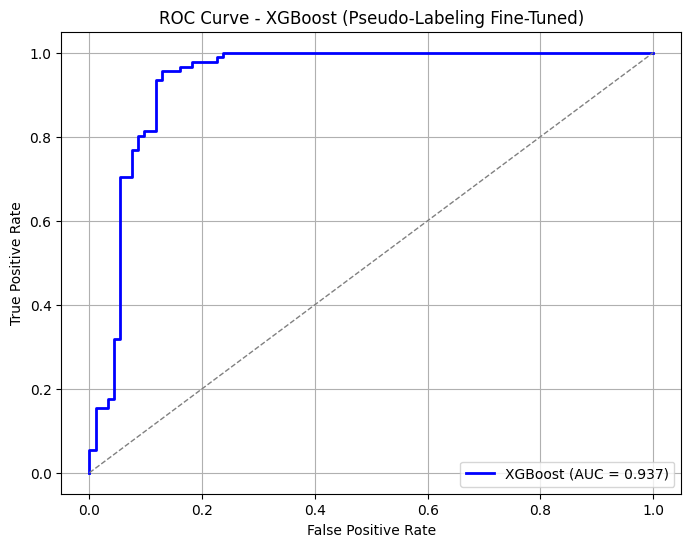

In [10]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import joblib

# 1. Load the model (if 'best_xgb_pipeline_v2' is already in session, you can skip this)
# If the Colab session was restarted, reload the model:
# best_xgb_pipeline_v2 = joblib.load("/content/models/best_xgb_pipeline_v2.pkl")

# 2. Predict probabilities (make sure to use predict_proba)
y_proba_xgb = best_xgb_pipeline.predict_proba(X_test_xgb)[:, 1]  # Take the probability of the positive class (1)

# 3. Compute False Positive Rate and True Positive Rate
fpr, tpr, thresholds = roc_curve(y_test_xgb, y_proba_xgb)

# 4. Calculate AUC
roc_auc = auc(fpr, tpr)

# 5. Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Pseudo-Labeling Fine-Tuned)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
print(len(y_test))

251
